# Study 2 – Descriptive Dataset Analysis
This notebook characterises the dataset used in this thesis at patient, recording 
and seizure level. It ensures transparency in the structure, quality and distribution 
of the available ECG + annotation data prior to further SQI/HRV analysis.

In [1]:
import sys
import jinja2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from src.hrv_epatch.plots.plotstyle import set_project_style, palette
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.isi import plot_isi_per_patient
from src.hrv_epatch.dataset.summary import (
    build_patient_summary,
    compute_within_recording_isi,
    compute_dataset_overview,
    summarise_isi,
    compute_isi_per_patient, 
    summarise_isi_per_patient,
)

set_project_style()

## 1. Load dataset (TDMS + annotations from 01_build)

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results")
LOAD_DIR = OUT_DIR / "Datastruct"

df_rec = pd.read_csv(
    LOAD_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    LOAD_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
df_rec.head(), df_evt.head()

STUDY2_OUT = OUT_DIR / "study2"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)


# Create copies to avoid unintentional modifications
df_rec_sum = df_rec.copy()
df_evt_sum = df_evt.copy()

## 2 Dataset-overview (Key metrics)

In [3]:
df_overview = compute_dataset_overview(df_rec, df_evt)
df_overview

print(df_overview.to_latex(index=False, float_format="%.2f"))

df_overview.to_csv(STUDY2_OUT / "dataset_overview.csv", index=False)

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Patients & 43.00 \\
Enrollments & 50.00 \\
Recordings & 72.00 \\
Total hours & 3264.03 \\
Total seizures & 149.00 \\
Median rec. duration (h) & 45.55 \\
IQR rec. duration (h) & 9.04 \\
\bottomrule
\end{tabular}



## 3 Gantt-figur

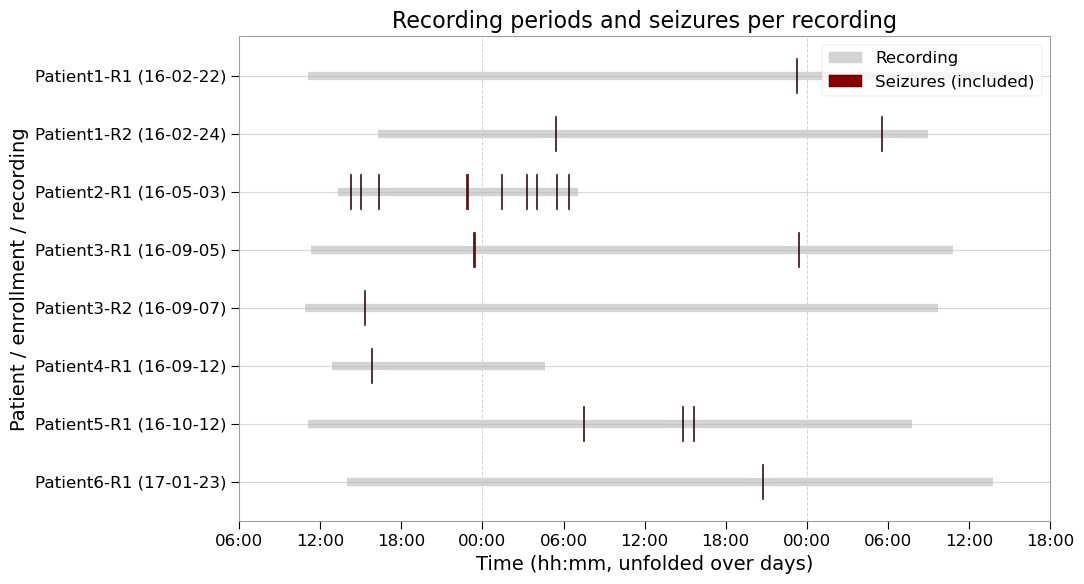

In [ ]:
# Gantt overview - Extra subset for visibility in rapport
# fig, ax = plot_gantt_from_index(df_rec[:8], df_evt, max_hours=96, figsize=(11, 6))
fig, ax = plot_gantt_from_index(df_rec, df_evt, max_hours=96, figsize=(11, 13))
fig.savefig(STUDY2_OUT / "study2_gantt_overview.png", dpi=500, bbox_inches="tight")

## 4 Patient-level summary
Total hours, number of recordings, number of seizures etc.

In [5]:
df_patient_summary = build_patient_summary(df_rec, df_evt)
# print(df_patient_summary)

print(df_patient_summary.to_latex(index=False, float_format="%.2f"))

df_patient_summary.to_csv(STUDY2_OUT / "patient_summary.csv", index=False)

\begin{tabular}{rlrrrr}
\toprule
Patient & Enrollment & Recordings & Total_hours & Total_seizures & Hours_per_seizure \\
\midrule
1 & - & 2 & 93.84 & 3.00 & 31.28 \\
2 & - & 1 & 17.75 & 9.00 & 1.97 \\
3 & - & 2 & 94.40 & 3.00 & 31.47 \\
4 & - & 1 & 15.81 & 1.00 & 15.81 \\
5 & - & 1 & 44.74 & 3.00 & 14.91 \\
6 & - & 2 & 89.01 & 1.00 & 89.01 \\
7 & - & 2 & 76.14 & 4.00 & 19.04 \\
8 & a & 2 & 94.57 & 1.00 & 94.57 \\
8 & b & 1 & 42.34 & 1.00 & 42.34 \\
9 & - & 2 & 68.25 & 3.00 & 22.75 \\
10 & - & 1 & 72.00 & 1.00 & 72.00 \\
11 & - & 2 & 90.50 & 6.00 & 15.08 \\
12 & - & 2 & 90.37 & 3.00 & 30.12 \\
13 & - & 2 & 73.17 & 8.00 & 9.15 \\
14 & - & 2 & 94.99 & 7.00 & 13.57 \\
15 & - & 2 & 121.77 & 1.00 & 121.77 \\
16 & - & 1 & 42.85 & 1.00 & 42.85 \\
17 & - & 1 & 19.21 & 1.00 & 19.21 \\
18 & - & 1 & 45.65 & 3.00 & 15.22 \\
19 & - & 1 & 48.02 & 3.00 & 16.01 \\
20 & - & 2 & 68.54 & 6.00 & 11.42 \\
21 & - & 2 & 119.79 & 1.00 & 119.79 \\
22 & - & 2 & 95.02 & 5.00 & 19.00 \\
23 & a & 1 & 43.14 & 1.00 &

# 4. A Total recording time for each patient/enrollment

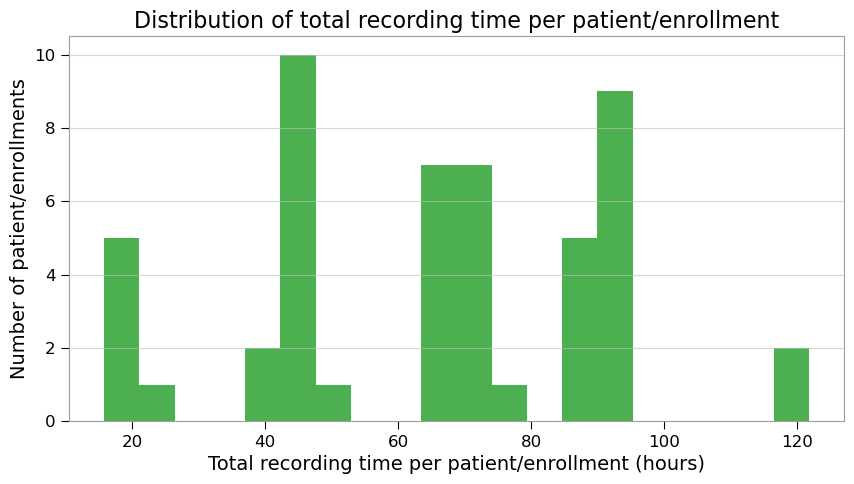

In [6]:
total_hours_pat = df_patient_summary["Total_hours"]

plt.figure(figsize=(10, 5))
plt.hist(total_hours_pat, bins=20, color=palette["primary"])
plt.xlabel("Total recording time per patient/enrollment (hours)")
plt.ylabel("Number of patient/enrollments")
plt.title("Distribution of total recording time per patient/enrollment")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 5 Recording duration distribution

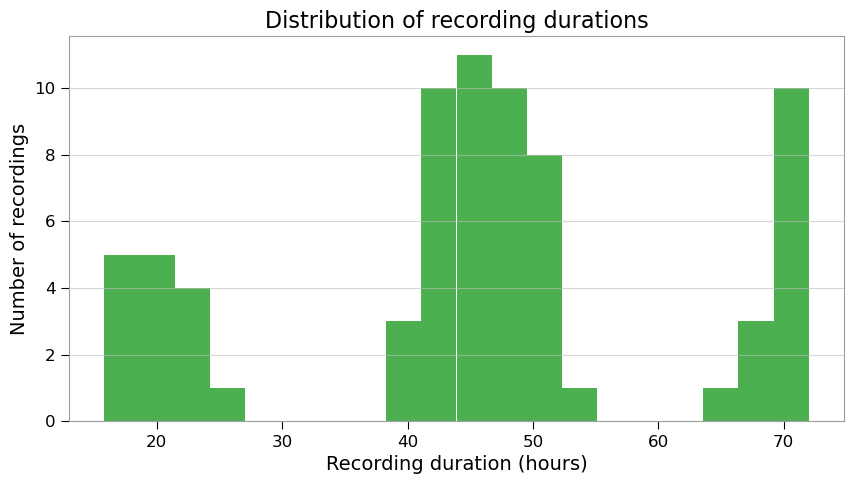

In [7]:
dur_hours = df_rec["rec_duration_s"] / 3600.0

plt.figure(figsize=(10, 5))
plt.hist(dur_hours, bins=20, color=palette["primary"])
plt.xlabel("Recording duration (hours)")
plt.ylabel("Number of recordings")
plt.title("Distribution of recording durations")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

## 6 Seizures pr. recording & pr. patient

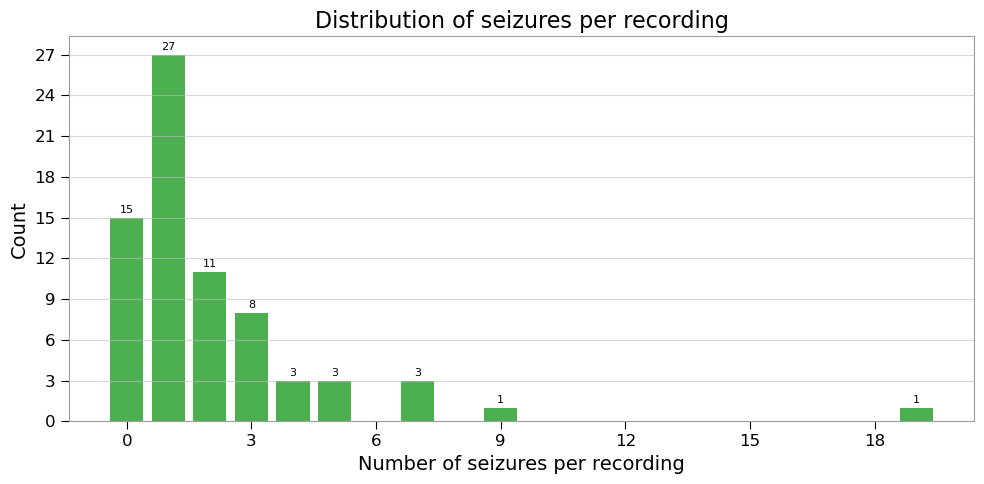

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Seizures per recording
seiz_per_rec = (
    df_evt
    .groupby("recording_uid")["seizure_id"]
    .count()
    .reindex(df_rec["recording_uid"], fill_value=0)
)

# Diskrete værdier og deres counts
values, counts = np.unique(seiz_per_rec.values, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(values, counts, width=0.8, color=palette["primary"])
for x, c in zip(values, counts):
    plt.text(x, c + 0.2, str(c), ha="center", va="bottom", fontsize=8)

plt.xlabel("Number of seizures per recording")
plt.ylabel("Count")
plt.title("Distribution of seizures per recording")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


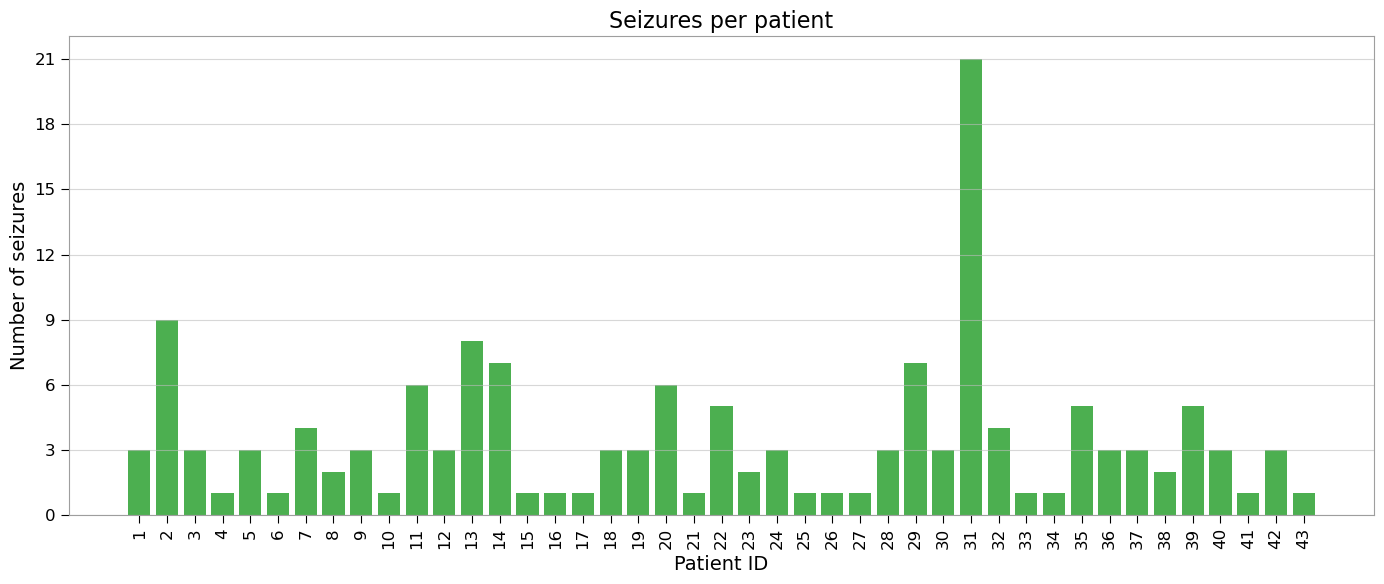

In [9]:
# Seizures per patient
seiz_per_patient = df_evt.groupby("patient_id")["seizure_id"].count()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(seiz_per_patient.index.astype(str), seiz_per_patient.values, color=palette["primary"])
ax.set_xlabel("Patient ID")
ax.set_ylabel("Number of seizures")
ax.set_title("Seizures per patient")
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.xticks(rotation=90)
plt.tight_layout()

fig.savefig(STUDY2_OUT / "seizures_per_patient.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
# Check columns in df_evt
df_evt.columns

Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'seizure_id', 't0', 't1', 'duration_s', 'absolute_start',
       'absolute_end', 'trim_start_s', 'trim_end_s', 't0_trim', 't1_trim',
       't0_video', 't1_video', 'absolute_start_video', 'absolute_end_video',
       't0_video_trim', 't1_video_trim', 't0_clinical', 't1_clinical',
       'absolute_start_clinical', 'absolute_end_clinical', 't0_clinical_trim',
       't1_clinical_trim'],
      dtype='object')

## 7 Seizure duration distribution

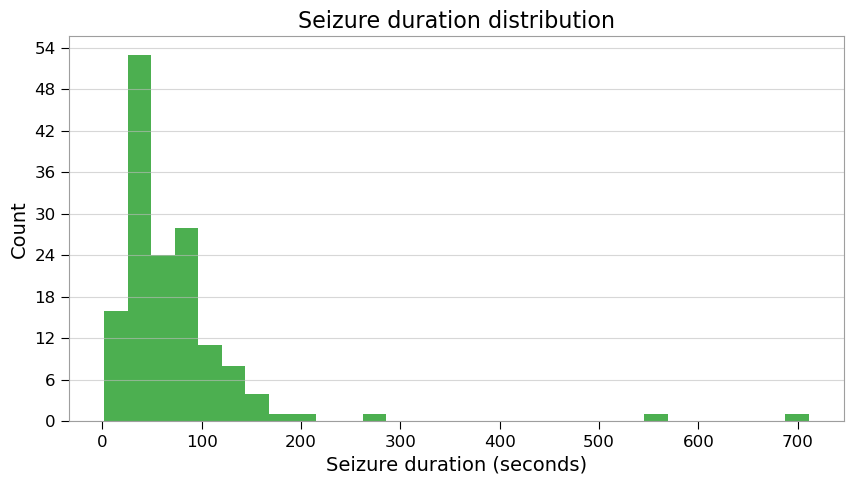

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_evt["duration_s"], bins=30, color=palette["primary"])
ax.set_xlabel("Seizure duration (seconds)")
ax.set_ylabel("Count")
ax.set_title("Seizure duration distribution")
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

fig.savefig(STUDY2_OUT / "seizure_duration_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

## 8 Time-of-day distribution for seizures

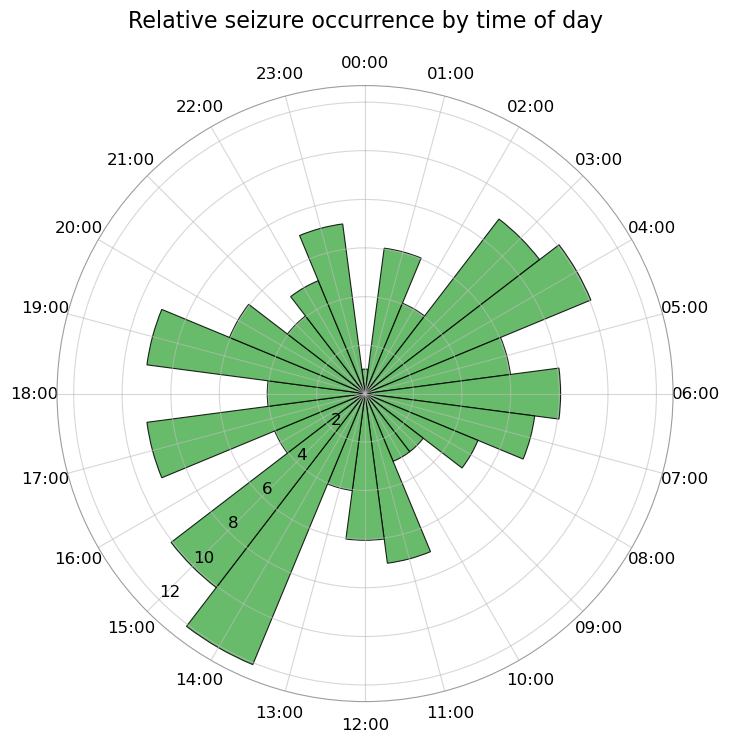

In [12]:
df_evt["hour_of_day"] = (
    df_evt["absolute_start"].dt.hour
    + df_evt["absolute_start"].dt.minute / 60
)

# Standard histogram (non-polar)
# plt.figure(figsize=(10, 5))
# plt.hist(df_evt["hour_of_day"], bins=24, color=palette["primary"])
# plt.xlabel("Hour of day")
# plt.ylabel("Number of seizures")
# plt.title("Seizure time-of-day distribution")
# plt.xticks(range(0, 24))

# ax = plt.gca()
# ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Farve – brug din primary palette
primary = palette["primary"]

# Konverter hour-of-day (0–24) til radianer
hours = df_evt["hour_of_day"].values
theta = (hours / 24) * 2 * np.pi

# Antal bins
bins = 24
bin_edges = np.linspace(0, 2 * np.pi, bins + 1)

# Beregn counts pr. bin
counts, _ = np.histogram(theta, bins=bin_edges)

# Konverter til procent
percent = (counts / counts.sum()) * 100

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="polar")

# Histogram som bar-plot i polar koordinater
ax.bar(
    x=bin_edges[:-1],
    height=percent,
    width=(2 * np.pi / bins),
    bottom=0,
    color=primary,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.8
)

# Formatér som et ur
ax.set_theta_zero_location("N")   # 0° = top (midnat)
ax.set_theta_direction(-1)        # Med uret (som et analogt ur)

# Time labels
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels([f"{h:02d}:00" for h in range(24)])

# Radial akse i procent
ax.set_rlabel_position(225)       # Placer radial-labels diskret
ax.set_yticks([1.33, 2.66, 4, 5.33, 6.67, 8])    # Justér efter behov
ax.set_yticklabels([f"{p}" for p in [2, 4, 6, 8, 10, 12]])

# Titel
plt.title("Relative seizure occurrence by time of day", pad=20)

fig.savefig(STUDY2_OUT / "seizure_time_of_day_polar.png", dpi=300, bbox_inches="tight")
plt.show()


## 9 Within-recording ISI + stats

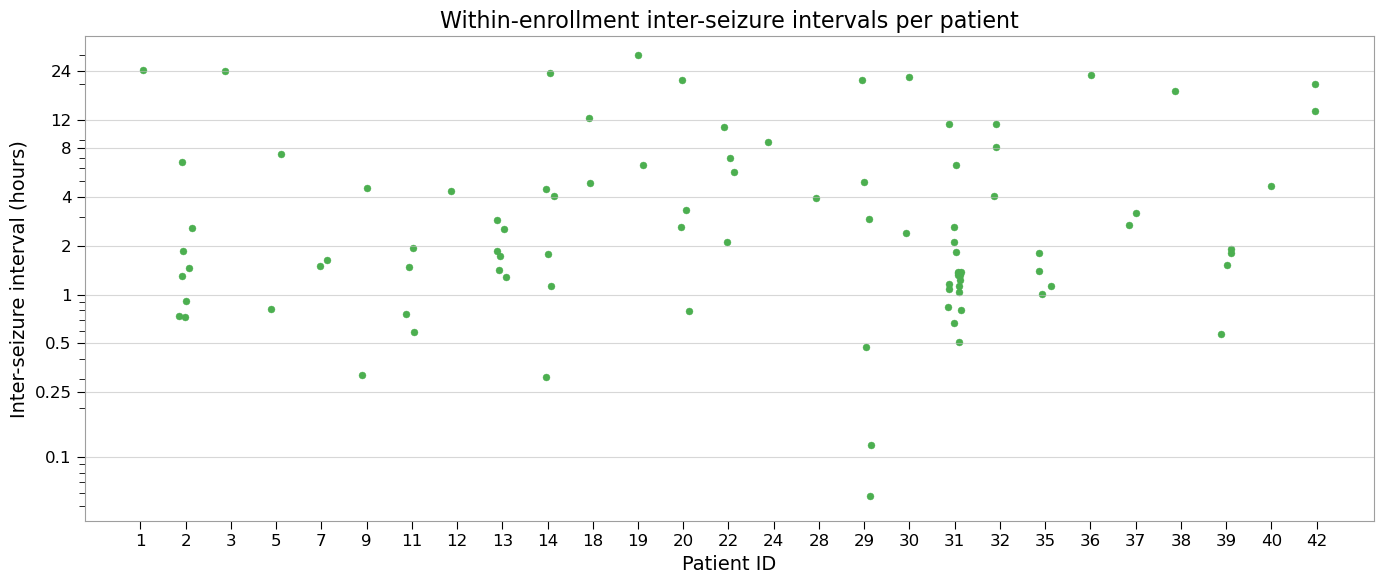

In [13]:
df_isi = compute_isi_per_patient(df_evt)

df_isi_stats = summarise_isi_per_patient(df_isi)
df_isi_stats.head()

plot_isi_per_patient(df_isi)

df_isi_stats.to_csv(STUDY2_OUT / "isi_within_stats.csv", index=False)

## 10 Export outputs

In [14]:
df_overview.to_csv(STUDY2_OUT / "dataset_overview.csv", index=False)
df_patient_summary.to_csv(STUDY2_OUT / "patient_summary.csv", index=False)
df_isi_stats.to_csv(STUDY2_OUT / "isi_within_stats.csv", index=False)

print("Saved Study2 outputs to:", STUDY2_OUT)

Saved Study2 outputs to: E:\Speciale - Results\study2
